## Red Bayesiana para toma de decisiones medicas

Miguel Gutierrez

Andres Salazar

**Librerias Necesarias para que funcione correctamente**: pyAgrum que depende de pydotplus ygraphviz

Para instalar Graphviz, es necesario descargar de su pagina inicial los binarios, ellos ya tienen instaladores por defecto.
https://graphviz.gitlab.io/download/

In [1]:
%load_ext autoreload
%autoreload 2

import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

Los diagramas de influencias son una representación gráfica de modelos de decisión que se complementan con los arboles de decisión. Los modelos de decisión permite a los médicos y analistas computar las utilidades esperadas en situaciones que involucran incertidumbre, complejidad y cambios dinámicos. Los diagramas de influencias  y los arboles de decisión son representaciones gráficas del mismo modelo matemático.

## Primero crearemos un problema simple de decision

In [3]:
diag=gum.InfluenceDiagram()
diag.addChanceNode(gum.LabelizedVariable("Fuente","Fuente",2))
diag.addDecisionNode(gum.LabelizedVariable("Decision","Decision",1))
diag.addUtilityNode(gum.LabelizedVariable("Utilidad","Utilidad",1))

2

In [4]:
diag

(gum::InfluenceDiagram<double>@0AFD2600) Influence Diagram{
  chance: 1,
  utility: 1,
  decision: 1,
  arcs: 0,
  domainSize: 2
}

Una de las ventajas al representar un problema con redes bayesianes, es que el tamaño del problema aumenta de manera lineal a medida que aumenta el tamaño del problema.

Un diagrama de influencia, contiene tres tipos de nodos:

1. **Nodos de Chance**: Representan variables aleatorias, mas bien probabilidades, estas son heredadas de las redes bayesianas originales. Se representan de forma circular.
2. **Nodos de decisión**: Representa las posibles alternativas a tomar. Este nodo esta conectado a los nodos chance/probabilidad cuyas distribuciones de probabilidad puedan afectar la decisión. Se representan de forma cuadrad.
3. **Nodos de Utilidad**: Es una variable aleatoria cuyo valor depende de sus nodos padres, que representa las posibles utilidades dado sus padres. Se representan en forma de rombo.

In [5]:
diag=gum.InfluenceDiagram()
F=diag.addChanceNode(gum.LabelizedVariable("Chance","Prob Stock",2))
D=diag.addDecisionNode(gum.LabelizedVariable("Decision","Invest",2))
U=diag.addUtilityNode(gum.LabelizedVariable("Utilidad","Expected Utility",1))
#Unir nodos
diag.addArc(D,U)
diag.addArc(F,U)
diag

(gum::InfluenceDiagram<double>@0B100290) Influence Diagram{
  chance: 1,
  utility: 1,
  decision: 1,
  arcs: 2,
  domainSize: 4
}

En un diagrama de influencia, se denomina el conjunto $A=\{a_1,a_2,...,a_n\}$, de posibles acciones que deben ser mutuamente excluyentes, y $H$ el conjunto de variables determinantes. La tabla de utilidad $U(A,H)$, es obtenida de configurar cada accione con cada variable determinante. El problema de maximización de utilidad se soluciona entonces maximizando:

$$E[U(a)]=\prod_H U(a,H)P(H|a)$$

Donde $U(a,H)$, son las entradas de elegir la accion $a$ con la variables $H$, más especificamente, son los nodos padres del nodo de utilidad $U$. Por otro lado la probabilidad condicional $P(H|a)$, se puede calcular calculando la probabilidad condicional de la variable $h_i\in H$, dada la accion $a$. A continuación mostramos un ejemplo de diagrama de influencia.

## Ejemplo

Consideremos el problema en el que ustes tiene \\$1000, y esta considerando comprar un stock de acciones $X$, cuyo precio actual es \\$10 por accion, el tiempo de espera es un mes, y un analista le comento que existe una probabilidad de $0.6$ que las acciones suban a \\$11 en un mes, mientras existe una probabilidad de 0.4, que se convierta en 0.9. Consideremos possibles acciones, invertir los \\$1000 en $X$ o no invertir.

In [6]:
diag=gum.InfluenceDiagram()
F=diag.addChanceNode(gum.LabelizedVariable("Stock","Prob Stock",2))
D=diag.addDecisionNode(gum.LabelizedVariable("Decision","Invest",2))
U=diag.addUtilityNode(gum.LabelizedVariable("Utility","Expected Utility",1))
#Unir nodos
diag.addArc(D,U)
diag.addArc(F,U)
diag

(gum::InfluenceDiagram<double>@0B100920) Influence Diagram{
  chance: 1,
  utility: 1,
  decision: 1,
  arcs: 2,
  domainSize: 4
}

Diremos que $0$ es no invertir y $1$ si decide invertir.

In [7]:
diag.cpt(F)[{'Decision':0}]=[1,0]
diag.cpt(F)[{'Decision':1}]=[0.6,0.4]

Verificamos, agregamos las probabilidades correspondientes.

In [8]:
diag.cpt(F)

(gum::Potential<double>@0B08BA70) <Stock:0> :: 0.6 /<Stock:1> :: 0.4

Incluimos la utilidad recibida de cada caso de si se presenta la subida de stock, y si se toma la decisión de invertir o no.

In [9]:
diag.utility(U)[{'Stock':0,'Decision':1}]=1100
diag.utility(U)[{'Stock':1,'Decision':1}]=900
diag.utility(U)[{'Stock':0,'Decision':0}]=1000
diag.utility(U)[{'Stock':1,'Decision':0}]=1000

In [10]:
ie=gum.InfluenceDiagramInference(diag)

In [11]:
table = diag.utility("Utility")
table

(gum::Potential<double>@0B08BB78) <Utility:0|Decision:0|Stock:0> :: 1000 /<Utility:0|Decision:1|Stock:0> :: 1100 /<Utility:0|Decision:0|Stock:1> :: 1000 /<Utility:0|Decision:1|Stock:1> :: 900

### Maximización de la Utilidad

Como ya presentamos anteriormente la maximización ocurre de tomar las decisiones que maximizan

$$\max E[U(a)]=\prod_H U(a,H)P(H|a)$$

En este ejemplo, el agente solo posee dos tipos de aciones $A=\{Invertir,No \ invertir\}$. Para esto calculamos el valor esperado de cada decision, primero la de invertir

$$E(D=1)=0.6($1100)+0.4($900)=1020$$

Luego la si decide no invertir:

$$E(D=0)=1000$$

In [12]:
ie.makeInference()
print("Best decision to invest or not : {0}".format(ie.getBestDecisionChoice(diag.idFromName("Decision"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to invest or not : 1
For a maxEU : 1020.0


Una vez entendemos como funciona un diagrama de decisión procederemos a modelar el problema de decisión de situación clinica de HIV. 

# Modelo HIV

El problema que modelaremos, sera la decisión de testear a un bebe nacido de una madre que es infectada con el virus imunidefiencia HIV con la reaction polimerasa PCR, una tecnica de amplificacion de genes que es util para el diagnostico de HIV en bebes. La primera decisión constara en eelegir si se debe realicar PCR, y la segunda, si se debe trata la infección con Pneumocystis pneumonia PCP, una vez el resultado es conocido. Este articulo en el que nos basamos es un poco, viejo, en ese entonces es recomendado, la iniciacon de un PCP infectados de HIV. El beneficio que modelaremoz, sera de la esperanza de vias mas larga ajustada por calidad, si se utiliza la profilaxis de la PCP en el lactante infectado por HIV. El modelo que se propondrá es entonces:

* El resultado PCR, depende de si el infante se encuentra infectado, el arco entre HIV estatus a PCR estas dos representa una dependencia probabilistica.
* Se presenta un arco entre del estado de HIV y tratamiento a QALE(Esperanza de vida ajustada por calidad). Pero no existe un arco entre PCR a QALE, esto pues,dado el conocimiento del estado de infeccion de VIH y de si el paciente ha sido tratado. 
* El QALE no depende del resultado PCR, puesto que si sabemos que el paciente realmente tiene HIV y dependiendo si el paciente fue tratado o no, la informacion del resultado, no afecta su expectativa de vida.
* El arco entre el resultado PCR y Tratamiento, inidica la decision que el paciente eligen una vez conoce el resultado para decidi entrarn en el tratamiento o no.
* El resutlado del PCR es positivo o negativo, condicionado al estado de HIV, y si el test fue ordenado.

Por otro lado si no existe un arco entre de un nodo de HIV estado a decision de tratamiento, indica que el tomador de la decision no ha observado del evento de HIV, para tomar la decisión. Esto es el decidido no conoce el estado de HIV, cuando decide tratarse o no.

La tabla de PCR plantea que el resultado que si el paciente es infectado de PCR la probabilidad de un resultado positivo ($HIV+$) es de 0.98, mientras por el contrario un resultado negativo($HIV-$) tiene una probabilidad de 0.02. De la misma manera si la alternativa elegia es no testearse con el PCR el resultano no se encuentra disponible con probabilidad 1. 

<img src="./Imagenes/Figura2.PNG" width="700px">

A continuacion mostramos la tabla que muestra los simbolos con sus respectivos significados.

<img src="./Imagenes/Tabla1.PNG" width="400px">

## Forma de evaluar los diagramas de influencia

Como los arboles de decision y los diagramasde influencia representan el mismo modelo, la forma de evaluar los diagramas de influencia es similar a como se evaluan los arboles de decisión.

1. Primero toma el valor esperado de cada nodo de chanes( Esto es sumando los productos de las probabilidades con la utilida de cada opcion probabilistica), sustitutye el valor esperado por el nodo, y repite el proceso hasta que encuentra un nodo de decisión. Este proceso se llama *removmiento de nodos de probabilidad*.
2. En el nodo de decision el analista toma una alternativa con la mayor utilidad esperada y remueve el nodo de decisión. Este proceso se llama *eliminacion de nodo de decision por determinación de politica*.


<img src="./Imagenes/Figura3.PNG" width="700px">

Se han presentado varios algoritmos par evaluar diagramas de influencia, el mas simple es el metodo de arco reverso y removimiento de noso, creado por Shachter.

## Algoritmo de evaluación

1. Eliminar todos los nodos(excepto los nodos de valor), que no apunto a otro nodo (nodos de barrera). En el ejemplo presentado anterior mente, tales nodos no existen.
2. Cuando ya no existan mas nodos que apunte a un nodo de valor/utilidad, hace lo siguiente:

    a. Si existe un nodo de decisión que apunto a un nodo de valor, y si todo los otros nodos que apuntan al valor nodo también apuntan al nodo de valor, también apunto al nodo de decisión, remover el nodo de decisión, por determinación de política. remover cualquier nodo (otro que no sea el nodo de valor), que no apunte a otro nodo.
    
    b. Si existe un nodo de posibilidad que apunte a un nodo de valor, removerlo por promedio, volver al paso 2.
    
    c. Encontrar un nodo de probabilidad que apunte a un nodo de valor y que no apunte a un nodo de decisión. Reversa los arcos(flechas), que apuntan del nodo de posibilidad a otro nodo de posibilidad que no cree un ciclo. Ahora el nodo de posibilidad apuntara solamente al nodo de valor. Volver al paso 2.
    
Algo importante que los autores recalcan, es que *a medida que se remueve un nodo, los hijos de los nodos heredan los arcos del nodo de valor/utilidad*

## Tratarse o no tratarse (Tratamiento clinico)

La modelación de tratamiento que trabajaremos sera :

<img src="./Imagenes/Figura7a.PNG" width="600px">

Comenzamos con el algoritmo donde el decedidor debete elegir si tratatse o no, si ninguna información como evidencia. No se presentan nodos de barrera. La condicion 2a, no se encuentra satisfechas --HIV Status no apunta a un nodo de decisión-- lo cual nos indica que el decididos no ha observado su estado HIV en el tiemp oque toma la decision,-- luego el nodo no puede ser removido todavia. Sin embargo la condicon del paso 2b son satisfechas, por lo tanto removemos el nodo *HIV status* promediandos. Al eliminar el nodo, QALE solo depende del nodo tratamiento y se calcula entonces la utilidad esperada de tratatse o no. Aca es raro, por que ya se sabe que la mejor opcion es tratarse en base al valor esperado, pero ellos siguen aplicando el algoritmo, probablemente, con fines ilustrativos. El valor esperado de tratarse es

* $$EU(Tx+)=p(HIV*)U(HIV+,Tx+)+P(HIV-)U(HIV-,Tx+)\\ = (0.08)(10.50 \ QALYs)+(0.92)(75.46 \ QALYs)\\=0.2632 \ QALYs$$


Mientras el valor esperado de no tratarse es 

* $$EU(Tx-)=p(Hiv*)U(HIV+,Tx-)+P(HIV-)U(HIV-,Tx-)\\ = (0.08)(10.0 \ QALYs)+(0.92)(75.5 \ QALYs)\\=0.2600 \ QALYs$$

De aca ya es posible deducir que la mejor decision sin ninguna evidencia alguna es tratarse. Ahora lo que se hace es aplicar el logaritmo, para evaluar todos los posibles casos en los que se encuentre evidencia elegir el mejor caso.

Para eliminar por promedios, debemos saber su valor, por lo tanto se reversa el arco que lo une con sus padres y se calcula sus probabilidades condicionales de la nueva tabla. Como en este caso no sucede el HIV status lo dejamos dependiente de el resultado PCR, y volvemos a calcular sus probabilidades. COMO ESAS SON LAS NUEVAS POSIBILIDADES?

<img src="./Imagenes/Figura7b.PNG" width="600px">

## Calculos

____________________________________________________________________
1. Calculo nueva tabla de PCR Result

Para calcular el nuevo $P(HIV+)_{PCR+1}$, procedemos a calcular:

$$P(HIV+)_{PCR+1}=P(HIV+)_{PCR}*P(HIV+)_{HIV Status}+P(HIV-)_{PCR}*P(HIV-)_{HIV Status}$$

Esto es 

$$P(HIV+)_{PCR+1}=0.98\cdot0.08+0.02\cdot0.92$$


Luego $P(HIV-)_{PCR+1} = 1-P(HIV+)_{PCR+1}$

____________________________________________________________________
2. Calculo nueva probabilidad condicional HIV Status,

En este caso nos será útil utilizar el teorema de bayes que nos plantea :

$$ P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$

Para calcular las probabilidades de $HIV Status$ nuevas, por ejemplo $P(HIV*_{Status}|HIV+_{PCR \ Result}) = \frac{0.98\cdot0.08}{0.0968}=0.8099$

_______________________________________________________________________
_______________________________________________________________________

Despues procedemos a modificar los valores de utilidad de , para poder eliminar el nodo de HIV estatus, entonces.

* $$U(HIV+|Tx+)_{PCR+1}=P(HIV+_{HIV Status}|HIV+_{PCR \ Result})*U(HIV+|Tx+)+ \\ P(HIV-|HIV+_{PCR \ Result})*U(HIV-|Tx+)=22.8489$$


$\;$


* $$U(HIV+|Tx-)_{PCR+1}=P(HIV+_{HIV Status}|HIV+_{PCR \ Result})*U(HIV+|Tx-)+ \\ P(HIV-|HIV+_{PCR \ Result})*U(HIV-|Tx-)=22.4516$$

$\;$


* $$U(HIV-|Tx+)_{PCR+1}=P(HIV+_{HIV Status}|HIV-_{PCR \ Result})*U(HIV+|Tx+)+ \\ P(HIV-|HIV-_{PCR \ Result})*U(HIV-|Tx+)=75.3431$$

$\;$


* $$U(HIV-|Tx-)_{PCR+1}=P(HIV+_{HIV Status}|HIV-_{PCR \ Result})*U(HIV+|Tx-)+ \\ P(HIV-|HIV-_{PCR \ Result})*U(HIV-|Tx-)=75.3821$$


Remplazamos la utilidades, y podemos eliminar el nodo chance

<img src="./Imagenes/Figura7c.PNG" width="600px">

Luego volvemos al paso 2, escojemos el maximo nodo de decision sujeto a la codicion del resultado, y elegimos las mejores opciones condicionadas al PCR result. Esto es, si el resultado es $HIV+$, lo mejor es tratarse, si el resultado es negativo $HIV-$, lo mejor no es tratarse. 

<img src="./Imagenes/Figura7d.PNG" width="600px">

## Replicacion

Ahora lo que haremos es replicar utilizando la libreria y deberiamos llegar a los mismos resultados planteados por el articulo.

In [13]:
HIV1=gum.InfluenceDiagram()
S=HIV1.addChanceNode(gum.LabelizedVariable("HIV Status","HIV Status",2))
R=HIV1.addChanceNode(gum.LabelizedVariable("PCR Result","PCR Result",2))
T=HIV1.addDecisionNode(gum.LabelizedVariable("Treat?(Yes/No)","Treat?",2))
Q=HIV1.addUtilityNode(gum.LabelizedVariable("QALE","QALE",1))
#Unir nodos
HIV1.addArc(S,Q)
HIV1.addArc(S,R)
HIV1.addArc(R,T)
HIV1.addArc(T,Q)
HIV1

(gum::InfluenceDiagram<double>@0B101640) Influence Diagram{
  chance: 2,
  utility: 1,
  decision: 1,
  arcs: 4,
  domainSize: 8
}

Diremos que $0$ es para $HIV-$ y $1$ para $HIV+$

In [14]:
HIV1.cpt(S).fillWith([0.92,0.08])

(gum::Potential<double>@0B109FA0) <HIV Status:0> :: 0.92 /<HIV Status:1> :: 0.08

In [15]:
HIV1.cpt(R).var_names

['HIV Status', 'PCR Result']

In [16]:
HIV1.cpt(R)[{'HIV Status':1}] = [0.02, 0.98]
HIV1.cpt(R)[{'HIV Status':0}] = [0.98, 0.02]
HIV1.cpt(R)

(gum::Potential<double>@0B10A210) <PCR Result:0|HIV Status:0> :: 0.98 /<PCR Result:1|HIV Status:0> :: 0.02 /<PCR Result:0|HIV Status:1> :: 0.02 /<PCR Result:1|HIV Status:1> :: 0.98

In [17]:
HIV1.utility(Q)[{'HIV Status':1,'Treat?(Yes/No)':1}]=10.5
HIV1.utility(Q)[{'HIV Status':1,'Treat?(Yes/No)':0}]=10.0
HIV1.utility(Q)[{'HIV Status':0,'Treat?(Yes/No)':1}]=75.46
HIV1.utility(Q)[{'HIV Status':0,'Treat?(Yes/No)':0}]=75.50
HIV1.utility(Q)

(gum::Potential<double>@0B10A228) <QALE:0|HIV Status:0|Treat?(Yes/No):0> :: 75.5 /<QALE:0|HIV Status:1|Treat?(Yes/No):0> :: 10 /<QALE:0|HIV Status:0|Treat?(Yes/No):1> :: 75.46 /<QALE:0|HIV Status:1|Treat?(Yes/No):1> :: 10.5

Procedemos hacer la inferencia sin información.

In [18]:
ie=gum.InfluenceDiagramInference(HIV1)
ie.eraseAllEvidence()
ie.makeInference()
print("Best decision to Treat? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Treat?(Yes/No)"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to Treat? (Yes/No) : 1
For a maxEU : 70.29846400000001


Aca es posible notar, que se aplico el algoritmo y se llega al mismo resultado del articulo !, ahora pasemosle una evidencia, y nos debera resultar en una utilidad esperada calculada. Vamos a decir que el resutlado fue poistivo.

In [19]:
ie=gum.InfluenceDiagramInference(HIV1)
ie.eraseAllEvidence()
ie.setEvidence({'PCR Result':1})
ie.makeInference()
print("Best decision to Treat? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Treat?(Yes/No)"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to Treat? (Yes/No) : 1
For a maxEU : 22.847768595041323


Es posible notar, que en la figura c, es el mismo resultado, el modelo, funciona correctamente !

## Tratarse o no tratarse con test diagnostico


En este caso se asume que ya se pidio un test diagnostico, y que es posible saber el resultado al momento de realizar el tratamiento. En este momento ya no nos iremos explicando detalladamente el proceso del algoritmo, pues es similar al anterior solo por una modificación.

<img src="./Imagenes/Figura8a.PNG" width="600px">

Se hace el mismo procedimientoque anteriomente y se eliminar HIV Status, pero en este caso como HIV depende condicionalmente de PCR result y PCR, se crea una conexion entre Obtain PCR y PCR result a HIV Status.

<img src="./Imagenes/Figura8b.PNG" width="600px">

Ya se puede eliminar HIV Status, y los nodos ahora apuntan al nodo de valor QALE. Pero antes de elminar el HIV Status, es necesario calcular las nuevas utilidades esperadas, de cada posible combinacione de los padres de QALE : $HIV+,Tx+;HIV*,TX-;HIV_,TX+ y HIV-,Tx-$.

<img src="./Imagenes/Figura8c.PNG" width="600px">

Por ejemplo el calculo de los dos primeros valores es:

* $$U(HIV+|Tx+)_{PCR+1}=P(HIV+_{HIV Status}|HIV+_{PCR \ Result})*U(HIV+|Tx+)+ \\ P(HIV-|HIV+_{PCR \ Result})*U(HIV-|Tx+)=22.8489$$

* $$U(HIV+|Tx-)_{PCR+1}=P(HIV+_{HIV Status}|HIV+_{PCR \ Result})*U(HIV+|Tx-)+ \\ P(HIV-|HIV+_{PCR \ Result})*U(HIV-|Tx-)=22.4516$$


Despues se procede a eliminar el nodo de Treat? Por determiniacón de politica.

<img src="./Imagenes/Figura8d.PNG" width="600px">

Despues se procede a eliminar PCR result por promedio. <img src="./Imagenes/Figura8e.PNG" width="600px">

## Replicación 2

In [20]:
HIV1=gum.InfluenceDiagram()
S=HIV1.addChanceNode(gum.LabelizedVariable("HIV Status","HIV Status",2))
R=HIV1.addChanceNode(gum.LabelizedVariable("PCR Result","PCR Result",3))
T=HIV1.addDecisionNode(gum.LabelizedVariable("Treat?(Yes/No)","Treat?",2))
O=HIV1.addDecisionNode(gum.LabelizedVariable("Obtain PCR?(Yes/No)","Obtain PCR?",2))
Q=HIV1.addUtilityNode(gum.LabelizedVariable("QALE","QALE",1))
#Unir nodos
HIV1.addArc(S,Q)
HIV1.addArc(S,R)
HIV1.addArc(R,T)
HIV1.addArc(T,Q)
HIV1.addArc(O,R)
HIV1.addArc(O,T)
HIV1

(gum::InfluenceDiagram<double>@0B100C68) Influence Diagram{
  chance: 2,
  utility: 1,
  decision: 2,
  arcs: 6,
  domainSize: 24
}

In [21]:
HIV1.cpt(S).fillWith([0.92,0.08])

(gum::Potential<double>@0B10B660) <HIV Status:0> :: 0.92 /<HIV Status:1> :: 0.08

In [22]:
HIV1.cpt(R).var_names

['Obtain PCR?(Yes/No)', 'HIV Status', 'PCR Result']

In [23]:
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':1,'HIV Status':1}] = [0.02, 0.98,0]
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':1,'HIV Status':0}] = [0.98, 0.02,0]
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':0,'HIV Status':0}] = [0, 0,1]
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':0,'HIV Status':1}] = [0, 0,1]
HIV1.cpt(R)

(gum::Potential<double>@0B10B7C8) <PCR Result:0|HIV Status:0|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:1|HIV Status:0|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:2|HIV Status:0|Obtain PCR?(Yes/No):0> :: 1 /<PCR Result:0|HIV Status:1|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:1|HIV Status:1|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:2|HIV Status:1|Obtain PCR?(Yes/No):0> :: 1 /<PCR Result:0|HIV Status:0|Obtain PCR?(Yes/No):1> :: 0.98 /<PCR Result:1|HIV Status:0|Obtain PCR?(Yes/No):1> :: 0.02 /<PCR Result:2|HIV Status:0|Obtain PCR?(Yes/No):1> :: 0 /<PCR Result:0|HIV Status:1|Obtain PCR?(Yes/No):1> :: 0.02 /<PCR Result:1|HIV Status:1|Obtain PCR?(Yes/No):1> :: 0.98 /<PCR Result:2|HIV Status:1|Obtain PCR?(Yes/No):1> :: 0

In [24]:
HIV1.utility(Q)[{'HIV Status':1,'Treat?(Yes/No)':1}]=10.5
HIV1.utility(Q)[{'HIV Status':1,'Treat?(Yes/No)':0}]=10.0
HIV1.utility(Q)[{'HIV Status':0,'Treat?(Yes/No)':1}]=75.46
HIV1.utility(Q)[{'HIV Status':0,'Treat?(Yes/No)':0}]=75.50
HIV1.utility(Q)

(gum::Potential<double>@0B10B8A0) <QALE:0|HIV Status:0|Treat?(Yes/No):0> :: 75.5 /<QALE:0|HIV Status:1|Treat?(Yes/No):0> :: 10 /<QALE:0|HIV Status:0|Treat?(Yes/No):1> :: 75.46 /<QALE:0|HIV Status:1|Treat?(Yes/No):1> :: 10.5

In [25]:
ie=gum.InfluenceDiagramInference(HIV1)
ie.eraseAllEvidence()
ie.makeInference()
print("Best decision to Obtain PCR? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Obtain PCR?(Yes/No)"))))
print("Best decision to Treat? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Treat?(Yes/No)"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to Obtain PCR? (Yes/No) : 1
Best decision to Treat? (Yes/No) : 0
For a maxEU : 70.29846400000001


In [26]:
ie=gum.InfluenceDiagramInference(HIV1)
ie.eraseAllEvidence()
ie.setEvidence({'Obtain PCR?(Yes/No)':1,'PCR Result':0,'Treat?(Yes/No)':0})
ie.makeInference()
print("Best decision to Obtain PCR? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Obtain PCR?(Yes/No)"))))
print("Best decision to Treat? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Treat?(Yes/No)"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to Obtain PCR? (Yes/No) : 1
Best decision to Treat? (Yes/No) : 0
For a maxEU : 75.38396811337466


Es posible notar que llegamos a lo mismos resultados ! El modelo esta bien implementado

## Decision clinica compleja

Sgun las reglas de auto-cuidado de los hopistales, si la prevalencia de HIV infeccion es de 1% o mas, se deben ofrecer volutariamente resultados de HIV a todos los pacientes. Se modelara el problema con una infección del 5%, ne este probleema se modelara para adultos, donde los test seran una seucneica de test de anticuerpos y Western >blot, utilizada para test en adultos. El modelo que se planteara, modelara el beneficio de que una persona se realize un test y el benefico de los compañeros sexuales, quienes se identifica con $HIV$. Se asume que la intervencion medica, incluida la prophylaxis de infecciones oportunistas y un tratamiento antiretoviral, extiende la vida aproximadameten un años, sin ajusto por calidad de vida.  Se asume que el 80% de las personas identificad on infeccion HIV, reduce el numero de contactos sexuales como resultado de consejo.

<img src="./Imagenes/Figura9.PNG" width="600px">

In [27]:
HIV1=gum.InfluenceDiagram()
S=HIV1.addChanceNode(gum.LabelizedVariable("HIV Status","HIV Status",2))
R=HIV1.addChanceNode(gum.LabelizedVariable("HIV Result","HIV Result",3))
C=HIV1.addChanceNode(gum.LabelizedVariable("Compliance with Medical Therapy","Compliance with Medical Therapy",2))
RB=HIV1.addChanceNode(gum.LabelizedVariable("Risk Behaviour","Risk Behaviour",2))
T=HIV1.addDecisionNode(gum.LabelizedVariable("Treat?(Yes/No)","Treat?",2))
O=HIV1.addDecisionNode(gum.LabelizedVariable("Screen?(Yes/No)","Screen?",2))
Q=HIV1.addUtilityNode(gum.LabelizedVariable("QALE","QALE",1))
#Unir nodos
HIV1.addArc(S,Q)
HIV1.addArc(S,R)
HIV1.addArc(R,T)
HIV1.addArc(O,R)
HIV1.addArc(O,T)
HIV1.addArc(T,RB)
HIV1.addArc(T,C)
HIV1.addArc(RB,Q)
HIV1.addArc(C,Q)
HIV1

(gum::InfluenceDiagram<double>@0B100FB0) Influence Diagram{
  chance: 4,
  utility: 1,
  decision: 2,
  arcs: 9,
  domainSize: 96
}

In [28]:
HIV1.cpt(S).fillWith([0.92,0.08])

(gum::Potential<double>@0B113488) <HIV Status:0> :: 0.92 /<HIV Status:1> :: 0.08

In [29]:
HIV1.cpt(R)[{'Screen?(Yes/No)':1,'HIV Status':1}] = [0.02, 0.98,0]
HIV1.cpt(R)[{'Screen?(Yes/No)':1,'HIV Status':0}] = [0.98, 0.02,0]
HIV1.cpt(R)[{'Screen?(Yes/No)':0,'HIV Status':0}] = [0, 0,1]
HIV1.cpt(R)[{'Screen?(Yes/No)':0,'HIV Status':1}] = [0, 0,1]
HIV1.cpt(R)

(gum::Potential<double>@0B1137E8) <HIV Result:0|HIV Status:0|Screen?(Yes/No):0> :: 0 /<HIV Result:1|HIV Status:0|Screen?(Yes/No):0> :: 0 /<HIV Result:2|HIV Status:0|Screen?(Yes/No):0> :: 1 /<HIV Result:0|HIV Status:1|Screen?(Yes/No):0> :: 0 /<HIV Result:1|HIV Status:1|Screen?(Yes/No):0> :: 0 /<HIV Result:2|HIV Status:1|Screen?(Yes/No):0> :: 1 /<HIV Result:0|HIV Status:0|Screen?(Yes/No):1> :: 0.98 /<HIV Result:1|HIV Status:0|Screen?(Yes/No):1> :: 0.02 /<HIV Result:2|HIV Status:0|Screen?(Yes/No):1> :: 0 /<HIV Result:0|HIV Status:1|Screen?(Yes/No):1> :: 0.02 /<HIV Result:1|HIV Status:1|Screen?(Yes/No):1> :: 0.98 /<HIV Result:2|HIV Status:1|Screen?(Yes/No):1> :: 0

In [30]:
HIV1.cpt(C)[{'Treat?(Yes/No)':1}] = [ 0.1,0.9]
HIV1.cpt(C)[{'Treat?(Yes/No)':0}] = [1,0]
HIV1.cpt(C)

(gum::Potential<double>@0B113950) <Compliance with Medical Therapy:0|Treat?(Yes/No):0> :: 1 /<Compliance with Medical Therapy:1|Treat?(Yes/No):0> :: 0 /<Compliance with Medical Therapy:0|Treat?(Yes/No):1> :: 0.1 /<Compliance with Medical Therapy:1|Treat?(Yes/No):1> :: 0.9

In [31]:
HIV1.cpt(RB)[{'Treat?(Yes/No)':1}] = [ 0.2,0.8]
HIV1.cpt(RB)[{'Treat?(Yes/No)':0}] = [1,0]
HIV1.cpt(RB)

(gum::Potential<double>@0B113938) <Risk Behaviour:0|Treat?(Yes/No):0> :: 1 /<Risk Behaviour:1|Treat?(Yes/No):0> :: 0 /<Risk Behaviour:0|Treat?(Yes/No):1> :: 0.2 /<Risk Behaviour:1|Treat?(Yes/No):1> :: 0.8

In [32]:
HIV1.utility(Q)[{'HIV Status':1,'Compliance with Medical Therapy':1,'Risk Behaviour':1}]=4.82
HIV1.utility(Q)[{'HIV Status':1,'Compliance with Medical Therapy':1,'Risk Behaviour':0}]=4.69
HIV1.utility(Q)[{'HIV Status':1,'Compliance with Medical Therapy':0,'Risk Behaviour':1}]=4.37
HIV1.utility(Q)[{'HIV Status':1,'Compliance with Medical Therapy':0,'Risk Behaviour':0}]=4.24
HIV1.utility(Q)[{'HIV Status':0,'Compliance with Medical Therapy':1,'Risk Behaviour':1}]=44.59
HIV1.utility(Q)[{'HIV Status':0,'Compliance with Medical Therapy':1,'Risk Behaviour':0}]=44.59
HIV1.utility(Q)[{'HIV Status':0,'Compliance with Medical Therapy':0,'Risk Behaviour':1}]=44.79
HIV1.utility(Q)[{'HIV Status':0,'Compliance with Medical Therapy':0,'Risk Behaviour':0}]=44.79
HIV1.utility(Q)

(gum::Potential<double>@0B113A88) <QALE:0|HIV Status:0|Risk Behaviour:0|Compliance with Medical Therapy:0> :: 44.79 /<QALE:0|HIV Status:1|Risk Behaviour:0|Compliance with Medical Therapy:0> :: 4.24 /<QALE:0|HIV Status:0|Risk Behaviour:1|Compliance with Medical Therapy:0> :: 44.79 /<QALE:0|HIV Status:1|Risk Behaviour:1|Compliance with Medical Therapy:0> :: 4.37 /<QALE:0|HIV Status:0|Risk Behaviour:0|Compliance with Medical Therapy:1> :: 44.59 /<QALE:0|HIV Status:1|Risk Behaviour:0|Compliance with Medical Therapy:1> :: 4.69 /<QALE:0|HIV Status:0|Risk Behaviour:1|Compliance with Medical Therapy:1> :: 44.59 /<QALE:0|HIV Status:1|Risk Behaviour:1|Compliance with Medical Therapy:1> :: 4.82

In [33]:
ie=gum.InfluenceDiagramInference(HIV1)
ie.eraseAllEvidence()
ie.makeInference()
print("Best decision to Screen?(Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Screen?(Yes/No)"))))
print("Best decision to Treat? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Treat?(Yes/No)"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to Screen?(Yes/No) : 1
Best decision to Treat? (Yes/No) : 0
For a maxEU : 41.58259359999999


In [34]:
ie=gum.InfluenceDiagramInference(HIV1)
ie.eraseAllEvidence()
ie.setEvidence({"HIV Status":1})
ie.makeInference()
print("Best decision to Screen?(Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Screen?(Yes/No)"))))
print("Best decision to Treat? (Yes/No) : {0}".format(ie.getBestDecisionChoice(HIV1.idFromName("Treat?(Yes/No)"))))
print("For a maxEU : {0}".format(ie.getMEU()))

Best decision to Screen?(Yes/No) : 0
Best decision to Treat? (Yes/No) : 0
For a maxEU : 4.749


_________________________________________________________________________
_________________________________________________________________________
_________________________________________________________________________


## Representaciones Graficas (No es necesario revisar)

Las siguientes representaciones graficas solo muestran mas bonita los nodos de probabilidad, pero de estas no es posible obtenr inferencias del diagrama de influencia. Los autores de la Libreria nos recomendaron dejar los nodos de decision y utilidad con distribución uniforme. y pasar como evidencia alguna decision tomada con probabilidad 1. (https://gitlab.com/agrumery/aGrUM/-/issues/57), puesto la libreria todavia no posee esa función.

## Replica 1

In [35]:
HIV1=gum.BayesNet('WaterSprinkler')
S=HIV1.add(gum.LabelizedVariable("HIV Status","HIV Status",2))
R=HIV1.add(gum.LabelizedVariable("PCR Result","PCR Result",2))
T=HIV1.add(gum.LabelizedVariable("Treat?(Yes/No)","Treat?",2))
Q=HIV1.add(gum.LabelizedVariable("QALE","QALE",1))
#Unir nodos
HIV1.addArc(S,Q)
HIV1.addArc(S,R)
HIV1.addArc(R,T)
HIV1.addArc(T,Q)
HIV1

(gum::BayesNet<double>@0B0FD9E0) BN{nodes: 4, arcs: 4, domainSize: 8, dim: 14}

In [36]:
HIV1.cpt(S).fillWith([0.92,0.08])

(gum::Potential<double>@0B14A288) <HIV Status:0> :: 0.92 /<HIV Status:1> :: 0.08

In [37]:
HIV1.cpt(R)[{'HIV Status':1}] = [0.02, 0.98]
HIV1.cpt(R)[{'HIV Status':0}] = [0.98, 0.02]

In [38]:
HIV1.cpt(T).fillWith([0.25,0.25,0.25,0.25])

(gum::Potential<double>@0B14A810) <Treat?(Yes/No):0|PCR Result:0> :: 0.25 /<Treat?(Yes/No):1|PCR Result:0> :: 0.25 /<Treat?(Yes/No):0|PCR Result:1> :: 0.25 /<Treat?(Yes/No):1|PCR Result:1> :: 0.25

In [39]:
HIV1.cpt(Q).fillWith([0.25,0.25,0.25,0.25])

(gum::Potential<double>@0B14A6D8) <QALE:0|HIV Status:0|Treat?(Yes/No):0> :: 0.25 /<QALE:0|HIV Status:1|Treat?(Yes/No):0> :: 0.25 /<QALE:0|HIV Status:0|Treat?(Yes/No):1> :: 0.25 /<QALE:0|HIV Status:1|Treat?(Yes/No):1> :: 0.25

In [40]:
%matplotlib inline
ie=gum.LazyPropagation(HIV1)
ie.setEvidence({'Treat?(Yes/No)':1})
ie.makeInference()

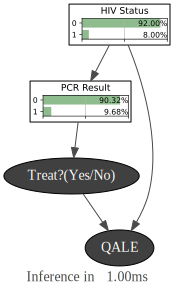

In [41]:
gnb.showInference(HIV1,evs={},targets={'PCR Result','HIV Status'})

## Replica 2

In [42]:
HIV1=gum.BayesNet('WaterSprinkler')
S=HIV1.add(gum.LabelizedVariable("HIV Status","HIV Status",2))
R=HIV1.add(gum.LabelizedVariable("PCR Result","PCR Result",3))
T=HIV1.add(gum.LabelizedVariable("Treat?(Yes/No)","Treat?",2))
O=HIV1.add(gum.LabelizedVariable("Obtain PCR?(Yes/No)","Obtain PCR?",2))
Q=HIV1.add(gum.LabelizedVariable("QALE","QALE",1))
#Unir nodos
HIV1.addArc(S,Q)
HIV1.addArc(S,R)
HIV1.addArc(R,T)
HIV1.addArc(T,Q)
HIV1.addArc(O,R)
HIV1.addArc(O,T)
HIV1

(gum::BayesNet<double>@0B0FD410) BN{nodes: 5, arcs: 6, domainSize: 24, dim: 32}

In [43]:
HIV1.cpt(S).fillWith([0.92,0.08])

(gum::Potential<double>@0B176028) <HIV Status:0> :: 0.92 /<HIV Status:1> :: 0.08

In [44]:
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':1,'HIV Status':1}] = [0.02, 0.98,0]
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':1,'HIV Status':0}] = [0.98, 0.02,0]
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':0,'HIV Status':0}] = [0, 0,1]
HIV1.cpt(R)[{'Obtain PCR?(Yes/No)':0,'HIV Status':1}] = [0, 0,1]
HIV1.cpt(R)

(gum::Potential<double>@0B1763D0) <PCR Result:0|HIV Status:0|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:1|HIV Status:0|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:2|HIV Status:0|Obtain PCR?(Yes/No):0> :: 1 /<PCR Result:0|HIV Status:1|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:1|HIV Status:1|Obtain PCR?(Yes/No):0> :: 0 /<PCR Result:2|HIV Status:1|Obtain PCR?(Yes/No):0> :: 1 /<PCR Result:0|HIV Status:0|Obtain PCR?(Yes/No):1> :: 0.98 /<PCR Result:1|HIV Status:0|Obtain PCR?(Yes/No):1> :: 0.02 /<PCR Result:2|HIV Status:0|Obtain PCR?(Yes/No):1> :: 0 /<PCR Result:0|HIV Status:1|Obtain PCR?(Yes/No):1> :: 0.02 /<PCR Result:1|HIV Status:1|Obtain PCR?(Yes/No):1> :: 0.98 /<PCR Result:2|HIV Status:1|Obtain PCR?(Yes/No):1> :: 0

In [45]:
HIV1.cpt(T).fillWith([1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,])

(gum::Potential<double>@0B1767A8) <Treat?(Yes/No):0|PCR Result:0|Obtain PCR?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):1|PCR Result:0|Obtain PCR?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):0|PCR Result:1|Obtain PCR?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):1|PCR Result:1|Obtain PCR?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):0|PCR Result:2|Obtain PCR?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):1|PCR Result:2|Obtain PCR?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):0|PCR Result:0|Obtain PCR?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):1|PCR Result:0|Obtain PCR?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):0|PCR Result:1|Obtain PCR?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):1|PCR Result:1|Obtain PCR?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):0|PCR Result:2|Obtain PCR?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):1|PCR Result:2|Obtain PCR?(Yes/No):1> :: 0.0833333

In [46]:
HIV1.cpt(O).fillWith([1/2,1/2])

(gum::Potential<double>@0B176760) <Obtain PCR?(Yes/No):0> :: 0.5 /<Obtain PCR?(Yes/No):1> :: 0.5

In [47]:
HIV1.cpt(Q).fillWith([1/4,1/4,1/4,1/4])

(gum::Potential<double>@0B176898) <QALE:0|HIV Status:0|Treat?(Yes/No):0> :: 0.25 /<QALE:0|HIV Status:1|Treat?(Yes/No):0> :: 0.25 /<QALE:0|HIV Status:0|Treat?(Yes/No):1> :: 0.25 /<QALE:0|HIV Status:1|Treat?(Yes/No):1> :: 0.25

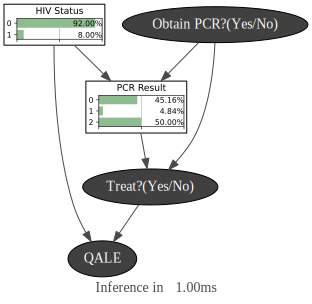

In [48]:
%matplotlib inline
ie=gum.LazyPropagation(HIV1)
ie.setEvidence({'Treat?(Yes/No)':1})
ie.makeInference()
gnb.showInference(HIV1,evs={},targets={'PCR Result','HIV Status'})

## Replica 3

In [49]:
HIV1=gum.BayesNet('WaterSprinkler')
S=HIV1.add(gum.LabelizedVariable("HIV Status","HIV Status",2))
R=HIV1.add(gum.LabelizedVariable("HIV Result","HIV Result",3))
C=HIV1.add(gum.LabelizedVariable("Compliance with Medical Therapy","Compliance with Medical Therapy",2))
RB=HIV1.add(gum.LabelizedVariable("Risk Behaviour","Risk Behaviour",2))
T=HIV1.add(gum.LabelizedVariable("Treat?(Yes/No)","Treat?",2))
O=HIV1.add(gum.LabelizedVariable("Screen?(Yes/No)","Screen?",2))
Q=HIV1.add(gum.LabelizedVariable("QALE","QALE",1))
#Unir nodos
HIV1.addArc(S,Q)
HIV1.addArc(S,R)
HIV1.addArc(R,T)
HIV1.addArc(O,R)
HIV1.addArc(O,T)
HIV1.addArc(T,RB)
HIV1.addArc(T,C)
HIV1.addArc(RB,Q)
HIV1.addArc(C,Q)
HIV1

(gum::BayesNet<double>@0B0FCB58) BN{nodes: 7, arcs: 9, domainSize: 96, dim: 44}

In [50]:
HIV1.cpt(S).fillWith([0.92,0.08])

(gum::Potential<double>@0B1BBEE0) <HIV Status:0> :: 0.92 /<HIV Status:1> :: 0.08

In [51]:
HIV1.cpt(R)[{'Screen?(Yes/No)':1,'HIV Status':1}] = [0.02, 0.98,0]
HIV1.cpt(R)[{'Screen?(Yes/No)':1,'HIV Status':0}] = [0.98, 0.02,0]
HIV1.cpt(R)[{'Screen?(Yes/No)':0,'HIV Status':0}] = [0, 0,1]
HIV1.cpt(R)[{'Screen?(Yes/No)':0,'HIV Status':1}] = [0, 0,1]
HIV1.cpt(R)

(gum::Potential<double>@0B1BC258) <HIV Result:0|HIV Status:0|Screen?(Yes/No):0> :: 0 /<HIV Result:1|HIV Status:0|Screen?(Yes/No):0> :: 0 /<HIV Result:2|HIV Status:0|Screen?(Yes/No):0> :: 1 /<HIV Result:0|HIV Status:1|Screen?(Yes/No):0> :: 0 /<HIV Result:1|HIV Status:1|Screen?(Yes/No):0> :: 0 /<HIV Result:2|HIV Status:1|Screen?(Yes/No):0> :: 1 /<HIV Result:0|HIV Status:0|Screen?(Yes/No):1> :: 0.98 /<HIV Result:1|HIV Status:0|Screen?(Yes/No):1> :: 0.02 /<HIV Result:2|HIV Status:0|Screen?(Yes/No):1> :: 0 /<HIV Result:0|HIV Status:1|Screen?(Yes/No):1> :: 0.02 /<HIV Result:1|HIV Status:1|Screen?(Yes/No):1> :: 0.98 /<HIV Result:2|HIV Status:1|Screen?(Yes/No):1> :: 0

In [52]:
HIV1.cpt(C)[{'Treat?(Yes/No)':1}] = [ 0.1,0.9]
HIV1.cpt(C)[{'Treat?(Yes/No)':0}] = [1,0]
HIV1.cpt(C)

(gum::Potential<double>@0B1BC558) <Compliance with Medical Therapy:0|Treat?(Yes/No):0> :: 1 /<Compliance with Medical Therapy:1|Treat?(Yes/No):0> :: 0 /<Compliance with Medical Therapy:0|Treat?(Yes/No):1> :: 0.1 /<Compliance with Medical Therapy:1|Treat?(Yes/No):1> :: 0.9

In [53]:
HIV1.cpt(RB)[{'Treat?(Yes/No)':1}] = [ 0.2,0.8]
HIV1.cpt(RB)[{'Treat?(Yes/No)':0}] = [1,0]
HIV1.cpt(RB)

(gum::Potential<double>@0B1BC930) <Risk Behaviour:0|Treat?(Yes/No):0> :: 1 /<Risk Behaviour:1|Treat?(Yes/No):0> :: 0 /<Risk Behaviour:0|Treat?(Yes/No):1> :: 0.2 /<Risk Behaviour:1|Treat?(Yes/No):1> :: 0.8

In [54]:
HIV1.cpt(T).fillWith([1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,1/12,])

(gum::Potential<double>@0B1BCAC8) <Treat?(Yes/No):0|HIV Result:0|Screen?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):1|HIV Result:0|Screen?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):0|HIV Result:1|Screen?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):1|HIV Result:1|Screen?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):0|HIV Result:2|Screen?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):1|HIV Result:2|Screen?(Yes/No):0> :: 0.0833333 /<Treat?(Yes/No):0|HIV Result:0|Screen?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):1|HIV Result:0|Screen?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):0|HIV Result:1|Screen?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):1|HIV Result:1|Screen?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):0|HIV Result:2|Screen?(Yes/No):1> :: 0.0833333 /<Treat?(Yes/No):1|HIV Result:2|Screen?(Yes/No):1> :: 0.0833333

In [55]:
HIV1.cpt(O).fillWith([1/2,1/2])

(gum::Potential<double>@0B1BC978) <Screen?(Yes/No):0> :: 0.5 /<Screen?(Yes/No):1> :: 0.5

In [56]:
HIV1.cpt(Q).fillWith([1/8,1/8,1/8,1/8,1/8,1/8,1/8,1/8])

(gum::Potential<double>@0B1BCE58) <QALE:0|HIV Status:0|Risk Behaviour:0|Compliance with Medical Therapy:0> :: 0.125 /<QALE:0|HIV Status:1|Risk Behaviour:0|Compliance with Medical Therapy:0> :: 0.125 /<QALE:0|HIV Status:0|Risk Behaviour:1|Compliance with Medical Therapy:0> :: 0.125 /<QALE:0|HIV Status:1|Risk Behaviour:1|Compliance with Medical Therapy:0> :: 0.125 /<QALE:0|HIV Status:0|Risk Behaviour:0|Compliance with Medical Therapy:1> :: 0.125 /<QALE:0|HIV Status:1|Risk Behaviour:0|Compliance with Medical Therapy:1> :: 0.125 /<QALE:0|HIV Status:0|Risk Behaviour:1|Compliance with Medical Therapy:1> :: 0.125 /<QALE:0|HIV Status:1|Risk Behaviour:1|Compliance with Medical Therapy:1> :: 0.125

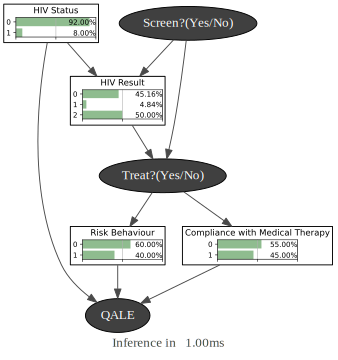

In [57]:
%matplotlib inline
ie=gum.LazyPropagation(HIV1)
ie.setEvidence({'Treat?(Yes/No)':1,'Screen?(Yes/No)':1})
ie.makeInference()
gnb.showInference(HIV1,evs={},targets={'PCR Result','HIV Result','Risk Behaviour','Compliance with Medical Therapy','HIV Status'})